In [1]:
# Feature Selection Notebook
# ==========================
# 
# This notebook contains the figures and calculations that were used to
# determine what features are relevant and appropriate to include in the
# ischemic heart disease model. 

library(Kendall)
library(tidyverse)
library(infotheo)
library(graphics)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
GIT_ROOT <- system2('git', args=c('rev-parse', '--show-toplevel'), stdout=TRUE)
DATA <- file.path(GIT_ROOT, 'data')
DATASET_PATH <- file.path(DATA, 'combined_data.csv')

In [3]:
# Print basic summary information about the a dataset including:
# - Total number of rows in the dataset.
# - For each column, how many rows are not null.
# - For each column, what fraction of rows are not null.
summarize_dataset <- function(dataset) {
    total_samples <- nrow(dataset)
    sprintf('total samples: %d\n', total_samples) %>% cat()
    for (column in names(dataset)) {
        not_null <- sum(complete.cases(dataset[[column]]))
        percent_not_null = not_null / total_samples * 100
        sprintf('%s (not null): %d (%.1f%%)\n', column, not_null, percent_not_null) %>% cat()
    }
    
}

In [4]:
# Perform a Shapiro-Wilk test on the given dataset for the target
# attribute grouped by heart disease class. Print the results
# to the standard output stream.
shapiro_by_class <- function(dataset, attribute) {
    for(num in 0:4) {
        population <- dataset[data$num == num,][[attribute]]
        normality <- shapiro.test(population)
        sprintf('Heart disease class %d Shapiro-Wilk p-value: %.4f\n', 
                num, 
                normality[['p.value']]) %>% cat()
    }
}

In [5]:
# Perform a Fligner-Killeen test on the given dataset for the
# target attribute grouped by heart disease class. Return
# the results of the test.
fligner_by_class <- function(dataset, attribute) {
    x <- list(zero=dataset[dataset$num == 0,][[attribute]],
              one=dataset[dataset$num == 1,][[attribute]],
              two=dataset[dataset$num == 2,][[attribute]],
              three=dataset[dataset$num == 3,][[attribute]],
              four=dataset[dataset$num == 4,][[attribute]])
    
    return(fligner.test(x))
}

In [6]:
# Find and return the outliers in the given dataset using the
# criteria that a sample below quantile .025 or above quantile
# .975 qualifies as an outlier.
outliers <- function(dataset) {
    lower_bound <- quantile(dataset, 0.025, na.rm=TRUE)
    upper_bound <- quantile(dataset, 0.975, na.rm=TRUE)
    outlier_indices <- which(dataset < lower_bound | dataset > upper_bound)
    return(sort(dataset[outlier_indices]))
}

In [7]:
# Construct and return a contingency table for the given dataset where
# heart disease class is the primary group and the target attribute
# is the sub-group, classes is a vector of all attribute classes, and
# labels is a vector of strings describing classes.
contingency_table <- function(dataset, attribute, classes, labels) {
    table <- data.frame()
    for(k in labels) table[[k]] <- as.numeric()
    for(num in 0:4) {
        row_values <- list()
        for(i in 1:length(classes)) {
            attribute_class <- classes[i]
            row_values[i] <- sum(dataset[dataset$num == num,][[attribute]] == attribute_class, na.rm=TRUE)  
        }
        #names(row_values) <- labels
        table <- rbind(table, row_values)
    }
    colnames(table) <- labels
    row.names(table) <- 0:4
    return(table)
}

In [8]:
# Construct and return a dataframe from the given dataset where 
# the heart disease class is grouped by the target attribute with
# classes given as a vector. The columns in the dataframe will be
# 'heart_disease_class', the name of the grouping attribute, and 
# 'fraction', which is the fraction of the attribute that belongs
# to the heart disease class given by the first column.
group_by_attribute <- function(dataset, attribute, classes) {
    class_totals <- list()
    for(i in 1:length(classes)) class_totals[i] <- sum(dataset[[attribute]] == classes[i], na.rm=TRUE)
    percent_totals <- list()
    categories <- list()
    categories_by_attribute <- data.frame()
    for(heart_disease_category in 0:4) {
        for(i in 1:length(classes)) {
            attribute_class <- classes[i]
            samples_per_category <- dataset[dataset$num == heart_disease_category,][[attribute]] == attribute_class
            sample_count <- sum(samples_per_category, na.rm=TRUE)
            class_total <- class_totals[[i]]
            percent_total <- sample_count / class_total
            categories_by_attribute <- rbind(categories_by_attribute, 
                                             c(heart_disease_category, attribute_class, percent_total))       
        }
    }
    colnames(categories_by_attribute) <- c('heart_disease_category', attribute, 'percent_total')
    return(categories_by_attribute)
}

In [9]:
heart_disease_data <- read_csv(DATASET_PATH)
sprintf('dataset: %s\n', DATASET_PATH) %>% cat()
summarize_dataset(heart_disease_data)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  thalrest = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  smoke = col_double(),
  cigs = col_double(),
  years = col_double(),
  famhist = col_double(),
  num = col_double()
)



dataset: /home/jgenson/Development/cardiac/data/combined_data.csv
total samples: 617
age (not null): 617 (100.0%)
sex (not null): 617 (100.0%)
cp (not null): 617 (100.0%)
thalrest (not null): 561 (90.9%)
trestbps (not null): 558 (90.4%)
chol (not null): 587 (95.1%)
fbs (not null): 527 (85.4%)
restecg (not null): 615 (99.7%)
thalach (not null): 562 (91.1%)
exang (not null): 562 (91.1%)
oldpeak (not null): 555 (90.0%)
slope (not null): 309 (50.1%)
smoke (not null): 230 (37.3%)
cigs (not null): 202 (32.7%)
years (not null): 190 (30.8%)
famhist (not null): 195 (31.6%)
num (not null): 617 (100.0%)


In [10]:
# Calculate the sample size for each heart disease class.
zeroes = sum(heart_disease_data$num == 0)
ones = sum(heart_disease_data$num == 1)
twos = sum(heart_disease_data$num == 2)
threes = sum(heart_disease_data$num == 3)
fours = sum(heart_disease_data$num == 4)
sprintf('0: %d\n', zeroes) %>% cat()
sprintf('1: %d\n', ones) %>% cat()
sprintf('2: %d\n', twos) %>% cat()
sprintf('3: %d\n', threes) %>% cat()
sprintf('4: %d\n', fours) %>% cat()

0: 247
1: 141
2: 99
3: 100
4: 30


In [11]:
# Summary statistics for age.
summary(heart_disease_data$age, na.rm=T)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  28.00   47.00   54.00   53.06   60.00   77.00 

In [12]:
# Potential outliers for age.
outliers(heart_disease_data$age)

[1] 28 29 29 30 31 31 32 32 32 32 32 33 33 72 72 72 72 73 74 74 74 74 74 74 75
[26] 75 75 76 77

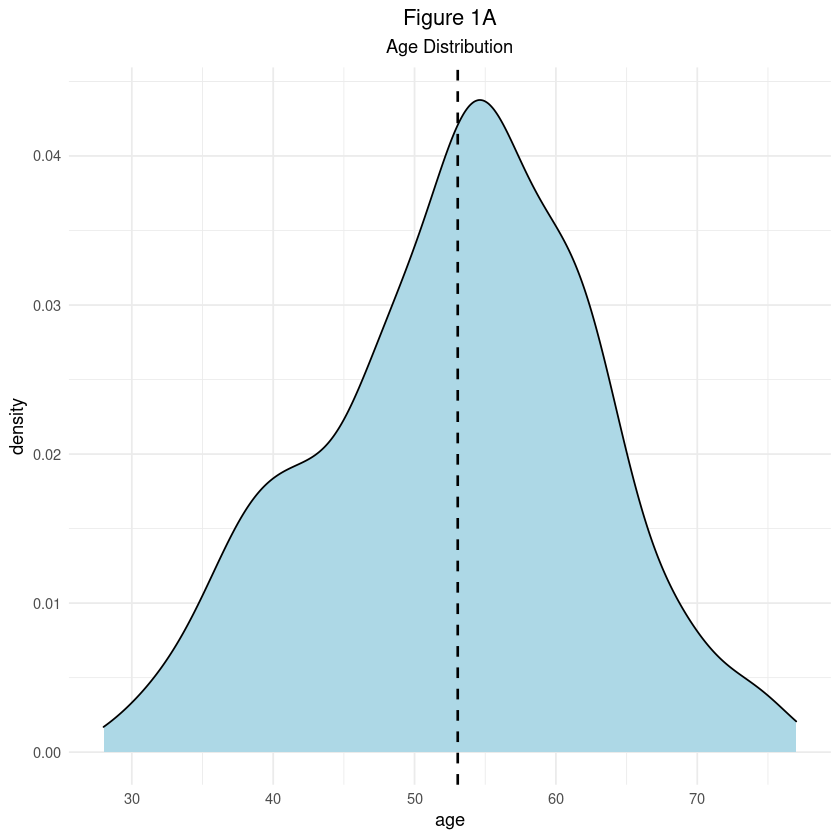

In [13]:
# Density plot of age.
ggplot(heart_disease_data, aes(x=age)) + ggtitle(label='Figure 1A', subtitle='Age Distribution') + geom_density(fill='lightblue') + geom_vline(aes(xintercept=mean(age)), linetype="dashed", size=.75) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

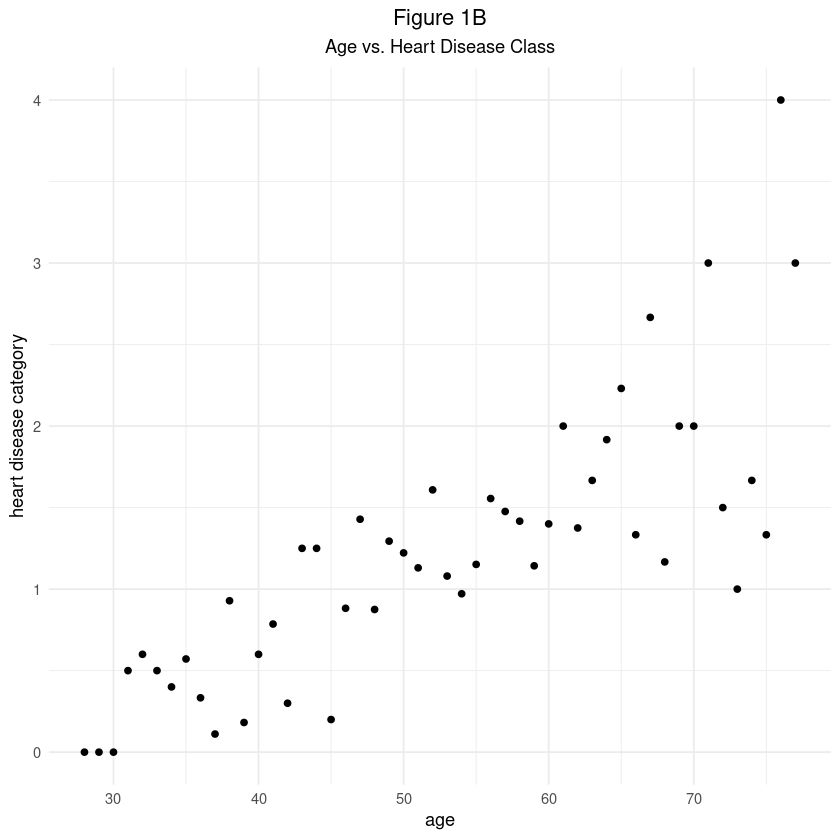

In [14]:
# Scatter plot showing age vs. average heart disease class.
average_class_per_age = aggregate(num ~ age, heart_disease_data, mean)
ggplot(average_class_per_age, aes(x=age, y=num)) + ggtitle(label='Figure 1B', subtitle='Age vs. Heart Disease Class') + ylab('heart disease category') + geom_point() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [15]:
# Shapiro-Wilk test for ages in each heart disesae class.
fligner_by_class(heart_disease_data, 'age')


	Fligner-Killeen test of homogeneity of variances

data:  x
Fligner-Killeen:med chi-squared = 5.1273, df = 4, p-value = 0.2745


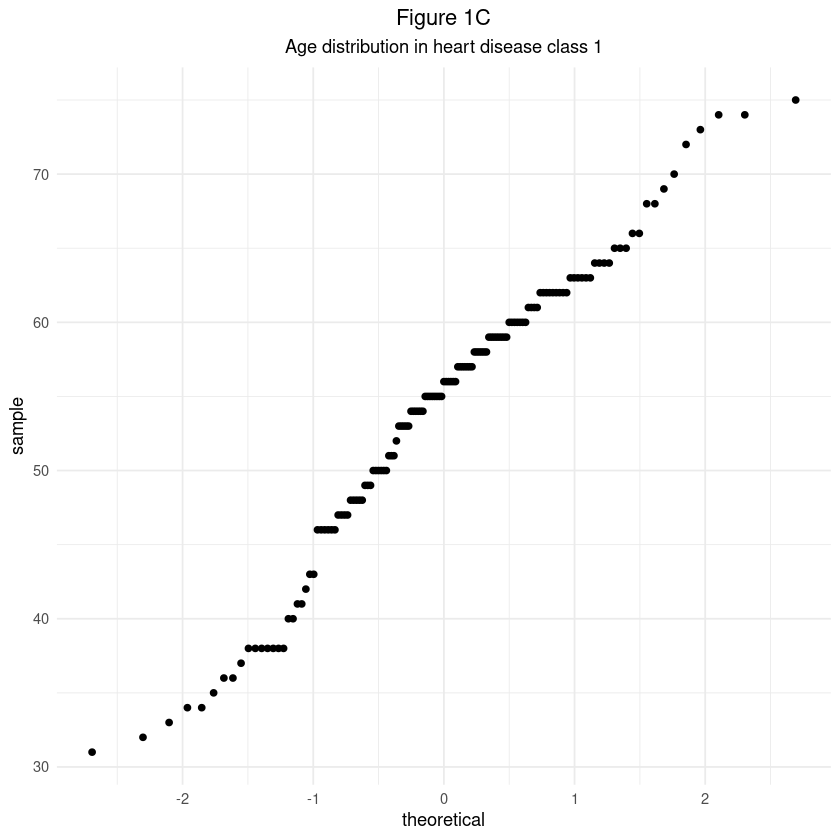

In [16]:
# Q-Q plot of ages in heart disease class 1
#
# The null hypothesis for the Shapiro-Wilk test was rejected for class 1,
# so we need to investigate it further. The Q-Q plot below appears to 
# show that the sample population is approximately normal.
category1_data <- heart_disease_data[heart_disease_data$num == 1,]
ggplot(category1_data, aes(sample=age)) + ggtitle(label='Figure 1C', subtitle='Age distribution in heart disease class 1') + stat_qq() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [17]:
# Fligner-Killeen test of age grouped by heart disease class.
#
# We fail to reject the null hypothesis for this test.
# Therefore, we treat the sample population variances as 
# approximately equal.
fligner_by_class(heart_disease_data, 'age')


	Fligner-Killeen test of homogeneity of variances

data:  x
Fligner-Killeen:med chi-squared = 5.1273, df = 4, p-value = 0.2745


In [18]:
# Test for outliers in ages in the target categories.
#
# Although there are some potential outliers, we can see from the 
# density plot and the listed outlier values that there is a small 
# number of them compared to the sample sizes and they are not extreme. 
class0_outliers <- outliers(heart_disease_data[heart_disease_data$num == 0,]$age)
cat('Category 0 outliers:\n')
print(category0_outliers)

class1_outliers <- outliers(heart_disease_data[heart_disease_data$num == 1,]$age)
cat('\nClass 1 outliers:\n')
print(category1_outliers)

class2_outliers <- outliers(heart_disease_data[heart_disease_data$num == 2,]$age)
cat('\nClass 2 outliers:\n')
print(category2_outliers)

class3_outliers <- outliers(heart_disease_data[heart_disease_data$num == 3,]$age)
cat('\nClass 3 outliers:\n')
print(category3_outliers)

class4_outliers <- outliers(heart_disease_data[heart_disease_data$num == 4,]$age)
cat('\nClass 4 outliers:\n')
print(category4_outliers)

Category 0 outliers:


ERROR: Error in print(category0_outliers): object 'category0_outliers' not found


In [ ]:
# ANOVA of age grouped by heart disease class.
#
# We reject the null hypothesis for this test and conclude
# that there is a correlation between age and heart disease
# class. Therefore, we include this feature in the model.
summary(aov(age ~ num, data=heart_disease_data))

In [ ]:
# Histogram of sex.
ggplot(heart_disease_data, aes(x=sex)) + ggtitle(label='Figure 2A', subtitle='Male/Female Distribution') + geom_histogram(binwidth=1, color='black', fill=c('orange', 'lightblue')) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Bar graph of sex grouped by heart disease classes.
#
# We can see from this graph that there is a much higher proportion
# of females in category 0 and a much higher proportion of males in
# categories 2 and 3, with a slightly higher proportion of males in
# categories 1 and 4. This suggests that there is an association 
# between being sex and heart disease category.
sex_by_class <- group_by_attribute(heart_disease_data, 'sex', c(0, 1))
ggplot(sex_by_class, aes(fill=sex, y=fraction, x=heart_disease_class)) + ggtitle(label='Figure 2B', subtitle='Sex grouped by heart disease class') + geom_bar(position=position_dodge2(), stat='identity', color='black') + theme_minimal() + scale_fill_gradient(low='orange', high='lightblue') + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Chi-square test for sex vs. heart disease class.
#
# The p-value for the Chi-square test is below the significance
# level .05, so we reject the null hypothesis and conclude that 
# sex and heart disease category are dependant variables. However,
# a warning arose arose from the Chi-square test function, so we
# will use mutual information to verify the association.
sex_contingency <- contingency_table(heart_disease_data, 'sex', c(0, 1), c('female', 'male'))
sex_contingency
chisq.test(sex_contingency)

In [ ]:
# Mutual information between sex and heart disease category.
#
# The mutual information between these variables is very close
# to 0, which is evidence against the hypothesis that sex and
# heart disease category are highly correlated. Furthermore, even 
# if there is an association between sex and heart disease category,
# it seems possible that there is no a causal relationship.
# For example, it could be that men are more likely to make smoke
# than women, which leads to a higher prevalence of heart disease
# among men. This would not, however, mean that being male inherently
# places one at a higher risk for heart disease. Therefore, this 
# attribute will be discluded from the model.
mutinformation(heart_disease_data$sex, heart_disease_data$num)

In [ ]:
# Histogram of cp (chest pain class).
ggplot(heart_disease_data, aes(x=cp)) + ggtitle(label='Figure 3A', subtitle='Histogram of Chest Pain Class') + geom_histogram(binwidth=1, color='black', fill=c('orange', 'red', 'darkblue', 'lightblue')) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Mosaic plot of chest pain class vs. heart disease class.
#
# The plot does not seem to indicate a clear association between 
# chest pain class and heart disease class.
cp_contingency <- contingency_table(heart_disease_data, 
                                    'cp', 
                                    c(4, 3, 1, 2), 
                                    c('asymptomatic', 'nonanginal', 'typical_anginal', 'atypical_anginal'))

mosaicplot(cp_contingency, shade=TRUE, las=2, main='Chest Pain Frequency')

In [ ]:
# Chi-square test of chest pain class vs. heart disease class.
# 
# The p-value for the Chi-square test is less than the significance
# level of 0.05, so we reject the null hypothesis and conclude that
# the variables are dependant on the basis of the test. However,
# the Chi-square test function issued a warning, so we will look at
# the mutual information to verify the association.
cp_contingency
chisq.test(cp_contingency)

In [ ]:
# Mutual information between chest pain and heart disease category.
#
# The low mutual information between these variables indicates a weak
# correlation between chest pain type and heart disease category. This
# is surprising, given that anginal chest pain is a classical symptom
# of heart disease in the medical literature. This may be due to a 
# misclassification of chest pain type in the data source. Similarly,
# this may be a poor choice for a model feature due to the difficulty
# in determining if chest pain is truly anginal without confirming the
# presence of heart disease (i.e. anginal pain implies heart disease).
# Of course, detecting the presence of heart disease is the very 
# purpose of the model, so this is not a suitable feature. However,
# we will now investigate whether a binary chest pain class - pain
# of any kind vs. no pain - may be suitable to include.
mutinformation(heart_disease_data$cp, heart_disease_data$num)

In [ ]:
# Bar graph of heart disease category grouped by binary cp class.
binary_cp_data <- data.frame(num=heart_disease_data$num,
                             cp=ifelse(heart_disease_data$cp == 4, 0, 1))

categories_by_binary_cp <- group_by_attribute(binary_cp_data, 'cp', c(0, 1))
ggplot(categories_by_binary_cp, aes(fill=cp, y=percent_total, x=heart_disease_category)) + ggtitle(label='Figure 3C', subtitle='Heart disease category group by binary chest pain class') + geom_bar(position=position_dodge2(), stat='identity', color='black') + theme_minimal() + scale_fill_gradient(low='lightblue', high='orange') + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Chi-square test of binary chest pain class vs. heart disease category.
#
# The p-value for the Chi-square test is less than the significance
# level of 0.05, so we reject the null hypothesis and conclude that
# the variables are dependant on the basis of the test. However,
# this result is suspect given that the above bar graph indicates
# the association is negative - the opposite of what the medical 
# literature indicates. Because of this, chest pain will not be
# included as a feature in the model.
binary_cp_contingency <- contingency_table(binary_cp_data, 
                                           'cp', 
                                           c(0, 1), 
                                           c('chest_pain_negative', 'chest_pain_positive'))

binary_cp_contingency
chisq.test(binary_cp_contingency)

In [ ]:
# Summary statistics for resting heart rate.
summary(heart_disease_data$thalrest, na.rm=TRUE)

In [ ]:
# Resting heart rate potential outliers.
outliers(heart_disease_data$thalrest)

In [ ]:
# Density plot of resting heart rates.
ggplot(heart_disease_data, aes(x=thalrest)) + ggtitle(label='Figure 4A', subtitle='Resting Heart Rates') + geom_density(fill='lightblue') + geom_vline(aes(xintercept=mean(thalrest, na.rm=TRUE)), linetype="dashed", size=.75) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Scatter plot showing average heart disease category per resting heart rate.
thalrest_mean_num = aggregate(num ~ thalrest, heart_disease_data, mean)
ggplot(thalrest_mean_num, aes(x=thalrest, y=num)) + ggtitle(label='Figure 4B', subtitle='Resting Heart Rate vs. Heart Disease Category') + ylab('heart disease category') + geom_point() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Compare the heart rate variance in each target class and
# whether or not the sample population is normally distributed.
# We fail to reject the null hypothesis that the data are not
# normally distributed for categories 2 and 4 as the p-values
# are above the predetermined significance level (0.05).
fligner_by_class(heart_disease_data, 'thalrest')

In [ ]:
# Q-Q plot of resting heart rates in heart disease category 2.
#
# Based on the plot, resting heart rates in heart disease
# category 2 do appear to be approximately normally distributed.
category2_data <- heart_disease_data[heart_disease_data$num == 2,]
ggplot(category2_data, aes(sample=thalrest)) + ggtitle(label='Figure 4C', subtitle='Resting heart rate distribution in heart disease category 2') + geom_qq() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Q-Q plot of resting heart rates in heart disease category 4.
#
# Based on the plot, resting heart rates in heart disease
# category 4 do appear to be approximately normally distributed.
category4_data <- heart_disease_data[heart_disease_data$num == 4,]
ggplot(category4_data, aes(sample=thalrest)) + ggtitle(label='Figure 4D', subtitle='Resting heart rate distribution in heart disease category 4') + geom_qq() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Fligner-Killeen test of thalrest grouped by heart disease category.
#
# The p-value for this test is below the chosen signifance level .05,
# so we reject the null hypothesis and conclude that the variance is
# not equal between these groups. Thus, we can not use ANOVA on this
# data.
fligner_by_class(heart_disease_data, 'thalrest')

In [ ]:
# Kendall's rank coefficient for resting heart rate vs. heart disease category.
#
# The p-value for this test is less than the chosen significance level (0.05),
# so we reject the null hypothesis that resting heart rate and heart disease
# category are not correlated. Furthermore, the scatter plot in Figure 4B
# indicates a correlation as well, so we include this feature in our model.
Kendall(heart_disease_data$thalrest, heart_disease_data$num)

In [ ]:
# Summary statistics for resting systolic blood pressure.
#
# The minimum value in this dataset is extremely suspicious,
# as a living person can not have a systolic blood pressure of 0.
summary(heart_disease_data$trestbps, na.rm=T)

In [ ]:
# Resting systolic blood pressure potential outliers.
#
# The systolic blood pressure value of 0 in this samples is almost
# certainly an error in the recording of the data. Therefore, this 
# datapoint should be discarded from the dataset.
outliers(heart_disease_data$trestbps)

In [ ]:
# Remove resting blood pressure 0 from the dataset.
data_wo_trestbps0 <- heart_disease_data[heart_disease_data$trestbps != 0,]

In [ ]:
# Density plot of resting systolic blood pressure (trestbps).
ggplot(data_wo_trestbps0, aes(x=trestbps)) + ggtitle(label='Figure 5A', subtitle='Resting Systolic Blood Pressure') + geom_density(fill='lightblue') + geom_vline(aes(xintercept=mean(trestbps, na.rm=TRUE)), linetype="dashed", size=.75) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Scatter plot showing average heart disease category per resting systolic blood pressure.
average_category_per_resting_bp = aggregate(num ~ trestbps, data_wo_trestbps0, mean)
ggplot(average_category_per_resting_bp, aes(x=trestbps, y=num)) + ggtitle(label='Figure 5B', subtitle='Resting Blood Pressure vs. Heart Disease Category') + ylab('heart disease category') + geom_point() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Compare the blood_pressure variance in each target category and
# whether or not the sample population is normally distributed.
# We failed to reject the null hypothesis that the data is not
# normally distributed for heart disease categories 2 and 4.
fligner_by_class(data_wo_trestbps0, 'trestbps')

In [ ]:
# Q-Q plot of resting blood pressure in heart disease category 2.
#
# The data do appear to be approximately normally distributed, however,
# there is a significant outlier. 
category2_data <- data_wo_trestbps0[data_wo_trestbps0$num == 2,]
ggplot(category2_data, aes(sample=trestbps)) + ggtitle(label='Figure 5C', subtitle='Resting blood pressure distribution in heart disease category 2') + geom_qq() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Q-Q plot of resting blood pressure in heart disease category 4.
#
# Despite the result of the Shapiro-Wilk test, these data do appear
# to be approximately normally distributed.
category4_data <- data_wo_trestbps0[data_wo_trestbps0$num == 4,]
ggplot(category4_data, aes(sample=trestbps)) + ggtitle(label='Figure 5D', subtitle='Resting blood pressure distribution in heart disease category 4') + geom_qq() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Fligner-Killeen test for resting systolic blood pressure vs. heart disease category.
#
# The p-value for this test is above the chosen significance level (0.05), so we fail 
# to reject the null hypothesis that the between-group variances are approximately 
# equal. However, although the p-value is above significance level 0.05, it is very
# close to it, so we will make sure the result of the ANOVA agrees with the scatter
# plot in Figure 5B.
fligner_by_class(data_wo_trestbps0, 'trestbps')

In [ ]:
# Potential outliers among resting blood pressure grouped by heart disease category.
#
# There are relatively few outliers compared to the sample sizes, and most of them
# are not extreme. Therefore we will perform ANOVA on the dataset, but we will perform
# it with and without the outliers included to see how they affect the result.
category0_outliers <- outliers(data_wo_trestbps0[data_wo_trestbps0$num == 0,]$trestbps)
cat('Category 0 outliers:\n')
print(category0_outliers)

category1_outliers <- outliers(data_wo_trestbps0[data_wo_trestbps0$num == 1,]$trestbps)
cat('\nCategory 1 outliers:\n')
print(category1_outliers)

category2_outliers <- outliers(data_wo_trestbps0[data_wo_trestbps0$num == 2,]$trestbps)
cat('\nCategory 2 outliers:\n')
print(category2_outliers)

category3_outliers <- outliers(data_wo_trestbps0[data_wo_trestbps0$num == 3,]$trestbps)
cat('\nCategory 3 outliers:\n')
print(category3_outliers)

category4_outliers <- outliers(data_wo_trestbps0[data_wo_trestbps0$num == 4,]$trestbps)
cat('\nCategory 4 outliers:\n')
print(category4_outliers)

In [ ]:
# ANOVA of resting systolic blood pressure grouped by heart disease category (including outliers).
#
# The p-value of ANOVA is less than the chosen significance level of 0.05,
# therefore we reject the null hypothesis that there is no association between
# resting systolic blood pressure and heart disease category. However, we need
# to repeat the ANOVA without outliers to verify the result of the test.
summary(aov(trestbps ~ num, data=data_wo_trestbps0))

In [ ]:
# ANOVA of resting systolic blood pressure grouped by heart disease category (excluding outliers).
#
# The p-value and F-value are approximately the same as the ANOVA with outliers.
# Therefore, based on the ANOVA and the scatter plot in Figure 5B, we conclude
# that there is a significant correlation between resting systolic blood pressure
# and heart disease category and include that feature in our model.
data_wo_trestbps_outliers <- heart_disease_data[-(heart_disease_data$trestbps %in% outliers(heart_disease_data$trestbps)),]
summary(aov(trestbps ~ num, data=data_wo_trestbps_outliers))

In [ ]:
# Summary statistics for cholesterol serum levels.
#
# The minimum and 1st quartile in this data are extremely
# suspicious. This indicates possible errors in the data.
summary(heart_disease_data$chol, na.rm=T)

In [ ]:
# Cholesterol serum levels potential outliers.
outliers(heart_disease_data$chol)

In [ ]:
# Density plot of cholesterol serum levels (chol).
#
# There are a large number outliers present at level 0. 
# This is almost certainly an error with the data, so we will remove them.
ggplot(heart_disease_data, aes(x=chol)) + ggtitle(label='Figure 6A', subtitle='Cholesterol Serum Levels') + geom_density(fill='lightblue') + geom_vline(aes(xintercept=mean(chol, na.rm=TRUE)), linetype="dashed", size=.75) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Remove cholesterol serum level outliers and check the data again.
data_wo_chol_outliers <- heart_disease_data[heart_disease_data$chol != 0,]
summarize_dataset(data_wo_chol_outliers)

In [ ]:
# Summary statistics for cholesterol serum levels without level 0 outliers.
summary(data_wo_chol_outliers$chol, na.rm=T)

In [ ]:
# Cholesterol serum levels potential outliers without level 0 outliers.
outliers(data_wo_chol_outliers$chol)

In [ ]:
# Density plot of cholesterol serum levels without level 0 outliers.
#
# This data appears to be a right-tailed distribution.
# Therefore, we will skip the tests for ANOVA and go straight to
# Kendall's rank coefficient.
ggplot(data_wo_chol_outliers, aes(x=chol)) + ggtitle(label='Figure 6B', subtitle='Cholesterol Serum Levels') + geom_density(fill='lightblue') + geom_vline(aes(xintercept=mean(chol, na.rm=TRUE)), linetype="dashed", size=.75) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Scatter plot showing average heart disease category per cholesterol serum level.
#
# The scatter plot is difficult to interpret because the variance in the data
# is high compared to the sample size. This does not necessarily indicate that
# the variables are uncorrelated. It is widely accepted in the medical literature
# that cholesterol serum level is predictive of heart disease, so we will not
# exclude it from the model unless the Kendall's rank coefficient is close to 0.
average_category_per_chol <- aggregate(num ~ chol, data_wo_chol_outliers, mean)
ggplot(average_category_per_chol, aes(x=chol, y=num)) + ggtitle(label='Figure 6C', subtitle='Cholesterol Serum Level vs. Heart Disease Category') + ylab('heart disease category') + geom_point() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Kendall's rank coefficient for cholesterol serum level vs. heart disease category.
#
# The p-value is less than the chosen significance level (0.05), so we reject
# the null hypothesis that the cholesterol serum level is not correlated with
# heart disease category. However, due to the comparatively small amount of good
# data available for this attribute, we will construct models with and without
# this feature and compare them.
Kendall(data_wo_chol_outliers$chol, data_wo_chol_outliers$num)

In [ ]:
# Histogram of fasting blood sugar levels.
ggplot(heart_disease_data, aes(x=fbs)) + ggtitle(label='Figure 7A', subtitle='Fasting Blood Sugar') + geom_histogram(binwidth=1, color='black', fill=c('lightblue', 'orange')) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Bar graph of heart disease categories grouped fasting blood sugar.
categories_by_fbs <- group_by_attribute(heart_disease_data, 'fbs', c(0, 1))
ggplot(categories_by_fbs, aes(fill=fbs, y=percent_total, x=heart_disease_category)) + ggtitle(label='Figure 7B', subtitle='Proportion of high blood sugar per heart disease category') + geom_bar(position=position_dodge2(), stat='identity', color='black') + theme_minimal() + scale_fill_gradient(low='lightblue', high='orange') + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Chi-square test of blood sugar vs. heart disease category.
#
# The p-value in the test is less than the chosen significance
# level of .05, therefore we reject the null hypothesis that 
# fasting blood sugar level and heart disease category are not
# dependant. However, due to the warning from the Chi-square test
# function, we will look at the mutual information between these
# variables as well.
fbs_contingency <- contingency_table(heart_disease_data,
                                     'fbs',
                                     c(0, 1),
                                     c('normal_blood_sugar', 'high_blood_sugar'))

fbs_contingency
chisq.test(fbs_contingency)

In [ ]:
# Mutual information between fasting blood sugar level and heart disease category.
#
# The mutual information between these variables is very low, which would
# normally indicate that there is no correlation between them. However,
# since the bar graph in Figure 7B and the Chi-square test indicate a
# significant correlation, we will try constructing the model with and
# without fasting blood sugar as a feature.
mutinformation(heart_disease_data$fbs, heart_disease_data$num)

In [ ]:
# Histogram of resting ECG categories.
ggplot(heart_disease_data, aes(x=restecg)) + ggtitle(label='Figure 8A', subtitle='Resting ECG Category') + geom_histogram(binwidth=1, color='black', fill=c('lightblue', 'orange', 'purple')) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Mosaic plot of resting ECG category vs. heart disease category.
restecg_contingency <- contingency_table(heart_disease_data,
                                         'restecg',
                                         c(0, 1, 2),
                                         c('normal', 'st_t_abnormality', 'lv_hypertrophy'))

mosaicplot(restecg_contingency, shade=TRUE, las=2, main='Figure 8B - Resting ECG Categories Frequency')

In [ ]:
# Chi-square test of resting ECG category vs. heart disease category.
#
# The p-value of this test is greater than the significance level (0.05),
# so we fail to reject the null hypothesis that the variables are
# independant. This is not surprising, because although the mosaic plot 
# in Figure 8B shows a correlation between the normal and ST-T abnormality
# ECG categories and the heart disease category, it shows no correlation
# between the left ventricular hypertrophy ECG category and heart disease
# category, and the sample size for left ventricular hypertrophy is so
# small that the result from a Chi-square test may not be valid. We will
# look at the mutual information this result.
restecg_contingency
chisq.test(restecg_contingency)

In [ ]:
# Mutual information between resting ECG category and heart disease category.
#
# The mutual information is very low, indicating (along with the Chi-square test)
# weak correlation between these variables. However, we will try these tests again,
# using a binary resting ECG class of ST-T abnormality and no ST-T abnormality 
# instead of a ternary classification.
mutinformation(heart_disease_data$restecg, heart_disease_data$num)

In [ ]:
# Chi-square test of binary resting ECG class vs. heart disease category.
#
# Although the p-value is still above the significance level, it is very
# close this time (borderline significant).
binary_restecg_data <- data.frame(num=heart_disease_data$num,
                                  restecg=ifelse(heart_disease_data$restecg != 1, 0, 1))

binary_restecg_contingency <- contingency_table(binary_restecg_data,
                                                'restecg',
                                                c(0, 1),
                                                c('normal', 'abnormal'))

binary_restecg_contingency
chisq.test(binary_restecg_contingency)

In [ ]:
# Mutual information between binary resting ECG class and heart disease category.
#
# Surprisingly, the mutual information remains largely unchanged between the ternary
# and binary ECG class datasets, although the Chi-square result improved substantially.
# It is unlikely that there is no correlation between ECG results and heart disease
# class, given the extensive support for this test in the medical literature and in
# clinical practice. The medical literature states that a resting ECG is normally 
# insufficient to diagnose coronary artery disease by itself unless ischemia  or 
# infarction are present during the test. However, the information from the resting 
# ECG is often useful in combination with the information from an exercise ECG. 
# For this reason, and the borderline result from the Chi-square test, we will include 
# the binary version of resting ECG class as a feature of the model.
mutinformation(binary_restecg_data$restecg, binary_restecg_data$num)

In [ ]:
# Summary statistics for peak exercise heart rate (thalach).
summary(heart_disease_data$thalach)

In [ ]:
# Peak exercise heart rate potential outliers.
outliers(heart_disease_data$thalach)

In [ ]:
# Density plot of peak exercise heart rates.
ggplot(heart_disease_data, aes(x=thalach)) + ggtitle(label='Figure 9A', subtitle='Peak Exercise Heart Rates') + geom_density(fill='lightblue') + geom_vline(aes(xintercept=mean(thalach, na.rm=TRUE)), linetype="dashed", size=.75) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Scatter plot of peak exercise heart rate vs. average heart disease category.
average_category_per_thalach = aggregate(num ~ thalach, heart_disease_data, mean)
ggplot(average_category_per_thalach, aes(x=thalach, y=num)) + ggtitle(label='Figure 9B', subtitle='Peak Exercise Heart Rate vs. Heart Disease Category') + ylab('heart disease category') + geom_point() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Compare the peak exercise heart rate variance in each target category and
# whether or not the sample populations are normally distributed.
#
# For all heart disease categories by category 0, we fail to reject the null
# hypothesis that the sample populations aren't normally distributed.
fligner_by_class(heart_disease_data, 'thalach')

In [ ]:
# Test if the peak exercise heart rate samples are balanced per heart disease category.
#
# The sample populations fail the test for balance.
thalach_num <- data.frame(age=factor(heart_disease_data$thalach), num=factor(heart_disease_data$num))
!is.list(replications(thalach ~ num, data=thalach_num))

In [ ]:
# Fligner-Killeen test for peak exercise heart rate vs. heart disease category.
#
# Since the p-value is greater than the signifance level of .05, we fail to
# reject the null hypothesis that the variances are equal. However, we can not
# use ANOVA on this data because it is not normally distributed or balanced.
fligner_by_class(heart_disease_data, 'thalach')

In [ ]:
# Kendall's rank coefficient for peak exercise heart rate vs. heart disease category.
#
# The p-value is lower than the significance level of .05, therefore we reject the
# null hypothesis that these variables are not correlated and we include this
# feature in our model.
Kendall(heart_disease_data$thalach, heart_disease_data$num)

In [ ]:
# Histogram of exang (exercise-induced angina).
ggplot(heart_disease_data, aes(x=exang)) + ggtitle(label='Figure 10A', subtitle='Exercise-induced Angina') + geom_histogram(binwidth=1, color='black', fill=c('lightblue', 'orange')) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Bar graph of heart disease categories grouped by exang (exercise-induced angina).
#
# The bar graph shows a clear correlation between exercise-induced angina and
# heart disease category. 
categories_by_exang <- group_by_attribute(heart_disease_data, 'exang', c(0, 1))
ggplot(categories_by_exang, aes(fill=exang, y=percent_total, x=heart_disease_category)) + ggtitle(label='Figure 10B', subtitle='Fraction of trestbps per heart disease category') + geom_bar(position=position_dodge2(), stat='identity', color='black') + theme_minimal() + scale_fill_gradient(low='lightblue', high='orange') + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Chi-square test of exercise-induced angina vs. heart disease category.
#
# The p-value is below the chosen significance level of .05, so we reject
# the null hypothesis that there is no correlation between exercise-induced
# angina and heart disease category. Both the Chi-square test and the
# bar graph indicate a correlation between these variables, so we will
# include exang in the model.
exang_contingency <- contingency_table(heart_disease_data,
                                       'exang',
                                       c(0, 1),
                                       c('negative', 'positive'))

exang_contingency
chisq.test(exang_contingency)

In [ ]:
# Summary statistics for ST-segment depression during exercise (oldpeak).
summary(heart_disease_data$oldpeak)

In [ ]:
# Density plot of ST-segment depression during exercise compared to baseline (oldpeak).
ggplot(heart_disease_data, aes(x=oldpeak)) + ggtitle(label='Figure 11A', subtitle='ST depression during exercise') + geom_density(fill='lightblue') + geom_vline(aes(xintercept=mean(oldpeak, na.rm=TRUE)), linetype="dashed", size=.75) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Scatter plot of oldpeak vs. average heart disease category.
#
# The scatter plot shows a clear correlation between ST-segement depression
# during exercise and heart disease category.
average_category_per_oldpeak = aggregate(num ~ oldpeak, heart_disease_data, mean)
ggplot(average_category_per_oldpeak, aes(x=oldpeak, y=num)) + ggtitle(label='Figure 11B', subtitle='Oldpeak vs. Heart Disease Category') + ylab('heart disease category') + geom_point() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Shapiro-Wilk test for oldpeak grouped by heart disease category.
#
# The p-value is below the significance level .05 for all categories
# but category 4. Therefore we reject the null hypothesis that the
# distributions are not normal for all categories except 4.
fligner_by_class(heart_disease_data, 'oldpeak')

In [ ]:
# Density plot of oldpeak in heart disease category 4.
#
# The distribution appears to be roughly normal with a mild
# left-tailed skew. However, this is close enough to normal
# to employ ANOVA.
category4_data <- heart_disease_data[heart_disease_data$num == 4,]
ggplot(category4_data, aes(sample=oldpeak)) + ggtitle(label='Figure 11C', subtitle='ST depression during exercise in heart disesae category 4 distribution') + geom_qq() + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Fligner-Killeen test for oldpeak vs. heart disease category.
#
# The p-value is less than the significance level of .05, so we
# reject the null hypothesis that the variances are the same.
# Thus, we can not use ANOVA on this data.
fligner_by_class(heart_disease_data, 'oldpeak')

In [ ]:
# Kendall's rank coefficient for oldpeak vs. heart disease category.
#
# The p-value is less than the significance level of .05, so we
# reject the null hypothesis that there is no correlation between
# ST-segment depression during exercise and heart disease category.
# Based on these results and the scatter plot in Figure 11B, we
# include this feature in our model.
Kendall(heart_disease_data$oldpeak, heart_disease_data$num)

In [ ]:
# Histogram of ST-segment slope during exercise (slope).
ggplot(heart_disease_data, aes(x=slope)) + ggtitle(label='Figure 12A', subtitle='ST-segment slope') + geom_histogram(binwidth=1, color='black', fill=c('lightblue')) + theme_minimal() + theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

In [ ]:
# Mosaic plot of slope vs. heart disease category.
#
# It does not appear from looking at the mosaic plot
# that there is a correlation between these variables.
slope_contingency <- contingency_table(heart_disease_data,
                                       'slope',
                                        c(1, 2, 3),
                                        c('upsloping', 'flat', 'downsloping'))

mosaicplot(slope_contingency, shade=TRUE, las=2, main='Figure 12B - Slope Frequency')

In [ ]:
# Chi-square test of slope vs. heart disease category.
#
# The p-value is greater than the significance level of .05,
# so we fail to reject the null hypothesis that there is no
# correlation between the variables.
slope_contingency
chisq.test(slope_contingency)

In [ ]:
# Mutual information between slope and heart disease category.
#
# According to the mutual information, there is no association
# between slope and heart disease category. This is surprising
# given that the medical literature recommends looking at the
# slope of the ST-segment depression as a standard clinical 
# practice during the commission of an exercise stress test,
# but both the mutual information and Chi-square test, as well
# as the mosaic plot in Figure 12B agree as to the lack of a
# strong correlation, so we exclude this feature from the model.
mutinformation(heart_disease_data$slope, heart_disease_data$num)